El presente notebook tiene como finalidad desarrollar algoritmos que permitan calcular sistemas de Recomendacion basados en las matrices UVS las cuales permiten descomponer la matriz principal en estas como X = U*S*V ... en algunos casos podria diferir en el sentido que V sea V.T (transpuesta)

# Librerias

In [4]:
# librerias

import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import time as time
## import seaborn as sns

# fin

# Definicion de algoritmo para sistema de recomendacion

## Opcion 01  - (U y V con Gradiente Exacto - S Descenso de Gradiente)  --- S solo en diagonal

In [5]:
######################### BLOQUE DE FUNCIONES A UTILIZAR ####################################################

def error_cuadratico2(Y,USV):
    ## Y es una matriz tipo Numpy
    ## UV es U*V pero sympy
    indices=np.argwhere(Y != 'n')
    Yn=sym.Matrix(Y)
    suma=0.0
    for x,y in indices:
        suma=suma+(Yn[x,y]-USV[x,y])**2
    return suma/2.0

################################################

def norma_2(M):
    a,b = M.shape
    total=0.0
    for ii in range(a):
        for jj in range(b):
            total=total+(M[ii,jj]**2)
    return total

################################################

def Costo2(U,S,V,X0,lambda_):
    # Funcion costo: error + regulador
    Jusv= error_cuadratico2(X0,U*S*V)+ (lambda_/2)*(norma_2(U))+(lambda_/2)*(norma_2(V))+(lambda_/2)*(norma_2(S))
    return Jusv

################################################


def Error_Total2(U,S,V,X0):
    return error_cuadratico2(X0,U*S*V)

################################################

## Nota: Aqui solo por referencia se coloca "Vit" e "Vt"
## pero dicha variable es reemplazable por Ui o Si 

def evalua_costo2(Jusv,Vit,Vt):
    Jusv_1 = Jusv.subs([(Vit,Vt)])
    return Jusv_1

################################################


def actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv=1,lambd=0.05,entero=0,alpha=0.5,posi=0,c_posi=0.001): ## actualizacion considerando U como fijo y Vt la variable a actualizar

## Donde X0 es la matriz objetivo
## U es la matriz U numerica
## Ui es la matriz simbolica de U solo en terminos de variables u[i,j]
## S es la matriz S numerica
## Si es la matriz simbolica de S solo en terminos de variables s[i,j], las cuales en este caso solo son las diagonales
## V es la matriz numerica
## Vit es la matriz simbolica de V solo en terminos de variables v[i,j]
## uv es la variable para indicar si se actualiza U,S o V.... usv == 1 se actualiza U, usv==2 se actualiza S, usv==3 se actualiza V 
## lambd es la variable de regularizacion de U, S y V para la actualizacion de los valores '''

    Jusv= error_cuadratico2(X0,Ui*Si*Vit)+ (lambd/2)*(norma_2(Ui))+(lambd/2)*(norma_2(Vit)) + (lambd/2)*(norma_2(Si))  ## Funcion de Costo total del modelo

##Jusv

    U_aux = U.copy() # redondear al entero mas cercano
    S_aux = S.copy() # redondear al entero mas cercano
    Vt_aux = Vt.copy() # redondear al entero mas cercano

    if(usv==1): ## se substituye en U
    #Jusv_1 = Jusv.subs([(Si,S)]) ## reemplazar los valores de S en Si ---- S va tener valores fijos.. Solo U es la variable
    #Jusv_1 = Jusv_1.subs([(Vit,Vt)]) ## reemplazar los valores de Vt en Vit ---- Vt va tener valores fijos.. Solo U es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Si,S),(Vit,Vt)])
        else:
            Jusv_1 =  Jusv.subs([(Si,S_aux),(Vit,Vt_aux)])
    elif(usv==2):
    #Jusv_1 = Jusv.subs([(Ui,U)])  ## reemplazar los valores de U en Ui ---- U va tener valores fijos.. Solo S es la variable
    #Jusv_1 = Jusv_1.subs([(Vit,Vt)]) ## reemplazar los valores de Vt en Vit ---- Vt va tener valores fijos.. Solo S es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Ui,U),(Vit,Vt)])
        else:
            Jusv_1 =  Jusv.subs([(Ui,U_aux),(Vit,Vt_aux)])
    elif(usv==3):
    #Jusv_1 = Jusv.subs([(Ui,U)])  ## reemplazar los valores de U en UI ---- U va tener valores fijos.. Solo V es la variable
    #Jusv_1 = Jusv_1.subs([(Si,S)])  ## reemplazar los valores de S en Si ---- S va tener valores fijos.. Solo V es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Ui,U),(Si,S)])
        else:
            Jusv_1 =  Jusv.subs([(Ui,U_aux),(Si,S_aux)])
    
    # Borrar de memoria variables auxiliares creadas
    del U_aux, S_aux, Vt_aux 

    W=None
    Wi=None

    if(usv==1):
        W=U.copy()
        Wi=Ui.copy()
    elif(usv==2):
        W=S.copy()
        Wi=Si.copy()
    elif(usv==3):
        W=Vt.copy()
        Wi=Vit.copy()
  
    # variable simbolica
    ix,jy=Wi.shape
    gradiente = sym.zeros(ix,jy)
  
    m=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
    kk=0
    for i in range(ix):
        for j in range(jy):
            gradiente[i,j]=sym.diff(Jusv_1,Wi[i,j])
            m[kk,0]=gradiente[i,j]
            
            ## OJO: Con optimizacion de gradiente EXACTO no se puede aplicar esta penalizacion 
            # Forzar a coeficientes positivos --- regularizacion/penalizacion por signo
            if(usv==2):
                if(posi>0):
                    m[kk,0]=gradiente[i,j]-c_posi*sym.exp(-Wi[i,j])
                
            # En caso ser la matriz diagonal S-Si ... solo actualizar la diagonal
            # las celdas que no pertenecen a la diagonal se coloca gradiente = 0.0 .. es decir sin entrenar dichos valores
            #if((usv==2) & (i != j)):
            #  m[kk,0]=0.0
        
            kk +=1

##########################################################################
######## Optimizacion mediante descenso de gradiente #####################

  # Entrenamiento de pesos mediante descenso de gradiente
  # Se realiza un entrenamiento por Descenso de Gradiente en caso de la matriz "S"
  
  # Observacion: El descenso de gradiente de "S" considera los parametros "alpha" para evitar problemas con la magnitud del gradiente
  
    if(usv ==2):
        v_nuevo = S.copy()
        gradiente_val = gradiente.subs([(Si,S)]) # se evalua la gradiente en el valor actual de "S"
        for i in range(v_nuevo.shape[0]):
            for j in range(v_nuevo.shape[1]):
        
                ## Definir como se realizará el Descenso de Gradiente para variables simbolicas de "S"

                ################################################################################################
                #### Opcion 01 ---- Solo se realizará descenso de Gradiente a la Diagonal de "S" ###############

                if(i==j):
                    v_nuevo[i,j] = v_nuevo[i,j] - alpha*gradiente_val[i,j] ## Los elementos de la diagonal se ajustan mediante descenso de gradiente
                else:
                    v_nuevo[i,j] = 0 ## Las celdas que no pertenece a la diagonal de S, se coloca su nuevo valor a 0
                    
                # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
                if(posi>0):
                    if(v_nuevo[i,j]<0):
                        v_nuevo[i,j]=0.0
                        
                ################################################################################################
                #### Opcion 02 ---- Solo se realizará descenso de Gradiente a todos los elementos de "S" ###############

                #v_nuevo[i,j] = v_nuevo[i,j] - alpha*gradiente_val[i,j] ## Los elementos de "S" se ajustan mediante descenso de gradiente

  
    # Optimizacion de Gradiente en el caso de "U" y "Vt"
    else:
    
        vv=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
        kk=0   
        for i in range(ix):
            for j in range(jy):
                vv[kk,0]=Wi[i,j]
                kk +=1
    
        vv_nuevo= sym.solve(m,vv,dict=False)  ## resolver las ecuaciones lineales
    
        valores=[]
        for i in vv_nuevo:
            valores.append(i)
    
    ##valores = list(uu_nuevo.keys())
    ##valores
    
        v_nuevo = sym.zeros(Wi.shape[0],Wi.shape[1])
        kk=0
   
        for i in range(Wi.shape[0]):
            for j in range(Wi.shape[1]):
                v_nuevo[i,j]=vv_nuevo[valores[kk]]
                
                # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
                if(posi>0):
                    if(v_nuevo[i,j]<0):
                        v_nuevo[i,j]=0.0
              
                # En las celdas del nuevo S que no pertenezcan a la diagonal se coloca a valor 0.0 
                #if((usv==2) & (i != j)):
                #  v_nuevo[i,j]=0.0

                kk +=1

#######################################################################
################### Actualizacion de valores ##########################

    # Inicializacion de variables a actualizar
    U_new = U.copy()
    S_new = S.copy()
    Vt_new = Vt.copy()

    # Se asignan nuevos valores
    if(usv==1):
        U_new=v_nuevo.copy()
    elif(usv==2):
        S_new=v_nuevo.copy()
    elif(usv==3):
        Vt_new=v_nuevo.copy()
    
    variacion_U = norma_2(U-U_new)
    variacion_S = norma_2(S-S_new)
    variacion_V = norma_2(Vt-Vt_new)
    variacion_error = Error_Total2(U_new,S_new,Vt_new,X0)-Error_Total2(U,S,Vt,X0) ## cambios de error.... Se espera un valor Negativo indicando que se redujo el error
    error_total = Error_Total2(U_new,S_new,Vt_new,X0)
    return U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total  ## regresa el nuevo U , S y Vt

##################################################################################################################

def resultados2(X0,U,S,Vt): ## en este caso se utiliza a V como la variable actualizada, U se mantuvo constante
    print('\n\n----------------------------')
    print('Matriz Objectivo X0: ')
    print(X0)
    print('\nMatriz obtenida: ')
    M = U*S*Vt
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            print('%.2f ' % (M[i,j]),end='')
        print('')

# fin

## Opcion 02  - (U,S y V Descenso de Gradiente) --- S solo en diagonal

In [6]:
######################### BLOQUE DE FUNCIONES A UTILIZAR ####################################################

def error_cuadratico2(Y,USV):
    ## Y es una matriz tipo Numpy
    ## UV es U*V pero sympy
    indices=np.argwhere(Y != 'n')
    Yn=sym.Matrix(Y)
    suma=0.0
    for x,y in indices:
        suma=suma+(Yn[x,y]-USV[x,y])**2
    return suma/2.0

################################################

def norma_2(M):
    a,b = M.shape
    total=0.0
    for ii in range(a):
        for jj in range(b):
            total=total+(M[ii,jj]**2)
    return total

################################################

def Costo2(U,S,V,X0,lambda_):
    # Funcion costo: error + regulador
    Jusv= error_cuadratico2(X0,U*S*V)+ (lambda_/2)*(norma_2(U))+(lambda_/2)*(norma_2(V))+(lambda_/2)*(norma_2(S))
    return Jusv

################################################


def Error_Total2(U,S,V,X0):
    return error_cuadratico2(X0,U*S*V)

################################################

## Nota: Aqui solo por referencia se coloca "Vit" e "Vt"
## pero dicha variable es reemplazable por Ui o Si 

def evalua_costo2(Jusv,Vit,Vt):
    Jusv_1 = Jusv.subs([(Vit,Vt)])
    return Jusv_1

################################################


def actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv=1,lambd=0.05,entero=0,alpha=0.5,posi=0,c_posi=0.001): ## actualizacion considerando U como fijo y Vt la variable a actualizar

## Donde X0 es la matriz objetivo
## U es la matriz U numerica
## Ui es la matriz simbolica de U solo en terminos de variables u[i,j]
## S es la matriz S numerica
## Si es la matriz simbolica de S solo en terminos de variables s[i,j], las cuales en este caso solo son las diagonales
## V es la matriz numerica
## Vit es la matriz simbolica de V solo en terminos de variables v[i,j]
## uv es la variable para indicar si se actualiza U,S o V.... usv == 1 se actualiza U, usv==2 se actualiza S, usv==3 se actualiza V 
## lambd es la variable de regularizacion de U, S y V para la actualizacion de los valores '''

    Jusv= error_cuadratico2(X0,Ui*Si*Vit)+ (lambd/2)*(norma_2(Ui))+(lambd/2)*(norma_2(Vit)) + (lambd/2)*(norma_2(Si))  ## Funcion de Costo total del modelo

##Jusv

    U_aux = U.copy() # redondear al entero mas cercano
    S_aux = S.copy() # redondear al entero mas cercano
    Vt_aux = Vt.copy() # redondear al entero mas cercano

    if(usv==1): ## se substituye en U
    #Jusv_1 = Jusv.subs([(Si,S)]) ## reemplazar los valores de S en Si ---- S va tener valores fijos.. Solo U es la variable
    #Jusv_1 = Jusv_1.subs([(Vit,Vt)]) ## reemplazar los valores de Vt en Vit ---- Vt va tener valores fijos.. Solo U es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Si,S),(Vit,Vt)])
        else:
            Jusv_1 =  Jusv.subs([(Si,S_aux),(Vit,Vt_aux)])
    elif(usv==2):
    #Jusv_1 = Jusv.subs([(Ui,U)])  ## reemplazar los valores de U en Ui ---- U va tener valores fijos.. Solo S es la variable
    #Jusv_1 = Jusv_1.subs([(Vit,Vt)]) ## reemplazar los valores de Vt en Vit ---- Vt va tener valores fijos.. Solo S es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Ui,U),(Vit,Vt)])
        else:
            Jusv_1 =  Jusv.subs([(Ui,U_aux),(Vit,Vt_aux)])
    elif(usv==3):
    #Jusv_1 = Jusv.subs([(Ui,U)])  ## reemplazar los valores de U en UI ---- U va tener valores fijos.. Solo V es la variable
    #Jusv_1 = Jusv_1.subs([(Si,S)])  ## reemplazar los valores de S en Si ---- S va tener valores fijos.. Solo V es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Ui,U),(Si,S)])
        else:
            Jusv_1 =  Jusv.subs([(Ui,U_aux),(Si,S_aux)])
    
    # Borrar de memoria variables auxiliares creadas
    del U_aux, S_aux, Vt_aux 

    W=None
    Wi=None

    if(usv==1):
        W=U.copy()
        Wi=Ui.copy()
    elif(usv==2):
        W=S.copy()
        Wi=Si.copy()
    elif(usv==3):
        W=Vt.copy()
        Wi=Vit.copy()
  
    # variable simbolica
    ix,jy=Wi.shape
    gradiente = sym.zeros(ix,jy)
  
    m=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
    kk=0
    for i in range(ix):
        for j in range(jy):
            gradiente[i,j]=sym.diff(Jusv_1,Wi[i,j])
            m[kk,0]=gradiente[i,j]

            # Forzar a coeficientes positivos --- regularizacion/penalizacion por signo
            if(posi>0):
                m[kk,0]=gradiente[i,j]-c_posi*sym.exp(-Wi[i,j])
                
            # En caso ser la matriz diagonal S-Si ... solo actualizar la diagonal
            # las celdas que no pertenecen a la diagonal se coloca gradiente = 0.0 .. es decir sin entrenar dichos valores
            #if((usv==2) & (i != j)):
            #  m[kk,0]=0.0
        
            kk +=1

##########################################################################
######## Optimizacion mediante descenso de gradiente #####################

  # Entrenamiento de pesos mediante descenso de gradiente
  # Se realiza un entrenamiento por Descenso de Gradiente en caso de la matriz "S"
  
  # Observacion: El descenso de gradiente de "S" considera los parametros "alpha" para evitar problemas con la magnitud del gradiente
  
    if(usv > 0):
        if(usv==1):
            v_nuevo = U.copy()
            vi_nuevo = Ui.copy()
        elif(usv==2):
            v_nuevo = S.copy()
            vi_nuevo = Si.copy()
        elif(usv==3):
            v_nuevo = Vt.copy()
            vi_nuevo = Vit.copy()
            
        gradiente_val = gradiente.subs([(vi_nuevo.copy(),v_nuevo.copy())]) # se evalua la gradiente en el valor actual de "S"
        for i in range(v_nuevo.shape[0]):
            for j in range(v_nuevo.shape[1]):
        
                ## Definir como se realizará el Descenso de Gradiente para variables simbolicas de "S"

                ################################################################################################
                #### Opcion 01 ---- Solo se realizará descenso de Gradiente a la Diagonal de "S" ###############
                
                if(usv==2):
                    if(i==j):
                        v_nuevo[i,j] = v_nuevo[i,j] - alpha*gradiente_val[i,j] ## Los elementos de la diagonal se ajustan mediante descenso de gradiente
                    else:
                        v_nuevo[i,j] = 0 ## Las celdas que no pertenece a la diagonal de S, se coloca su nuevo valor a 0

                ################################################################################################
                #### Opcion 02 ---- Solo se realizará descenso de Gradiente a todos los elementos de "S" ###############
                
                else:
                    v_nuevo[i,j] = v_nuevo[i,j] - alpha*gradiente_val[i,j] ## Los elementos de "S" se ajustan mediante descenso de gradiente

                # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
                if(posi>0):
                    if(v_nuevo[i,j]<0):
                        v_nuevo[i,j]=0.0                    
                    
#######################################################################
################### Actualizacion de valores ##########################

    # Inicializacion de variables a actualizar
    U_new = U.copy()
    S_new = S.copy()
    Vt_new = Vt.copy()

    # Se asignan nuevos valores
    if(usv==1):
        U_new=v_nuevo.copy()
    elif(usv==2):
        S_new=v_nuevo.copy()
    elif(usv==3):
        Vt_new=v_nuevo.copy()
    
    variacion_U = norma_2(U-U_new)
    variacion_S = norma_2(S-S_new)
    variacion_V = norma_2(Vt-Vt_new)
    variacion_error = Error_Total2(U_new,S_new,Vt_new,X0)-Error_Total2(U,S,Vt,X0) ## cambios de error.... Se espera un valor Negativo indicando que se redujo el error
    error_total = Error_Total2(U_new,S_new,Vt_new,X0)
    return U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total  ## regresa el nuevo U , S y Vt

##################################################################################################################

def resultados2(X0,U,S,Vt): ## en este caso se utiliza a V como la variable actualizada, U se mantuvo constante
    print('\n\n----------------------------')
    print('Matriz Objectivo X0: ')
    print(X0)
    print('\nMatriz obtenida: ')
    M = U*S*Vt
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            print('%.2f ' % (M[i,j]),end='')
        print('')

# fin

## Opcion 03  - (U y V con Gradiente Exacto - S Descenso de Gradiente) --- S libre, No Diagonal

In [7]:
######################### BLOQUE DE FUNCIONES A UTILIZAR ####################################################

def error_cuadratico2(Y,USV):
    ## Y es una matriz tipo Numpy
    ## UV es U*V pero sympy
    indices=np.argwhere(Y != 'n')
    Yn=sym.Matrix(Y)
    suma=0.0
    for x,y in indices:
        suma=suma+(Yn[x,y]-USV[x,y])**2
    return suma/2.0

################################################

def norma_2(M):
    a,b = M.shape
    total=0.0
    for ii in range(a):
        for jj in range(b):
            total=total+(M[ii,jj]**2)
    return total

################################################

def Costo2(U,S,V,X0,lambda_):
    # Funcion costo: error + regulador
    Jusv= error_cuadratico2(X0,U*S*V)+ (lambda_/2)*(norma_2(U))+(lambda_/2)*(norma_2(V))+(lambda_/2)*(norma_2(S))
    return Jusv

################################################


def Error_Total2(U,S,V,X0):
    return error_cuadratico2(X0,U*S*V)

################################################

## Nota: Aqui solo por referencia se coloca "Vit" e "Vt"
## pero dicha variable es reemplazable por Ui o Si 

def evalua_costo2(Jusv,Vit,Vt):
    Jusv_1 = Jusv.subs([(Vit,Vt)])
    return Jusv_1

################################################


def actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv=1,lambd=0.05,entero=0,alpha=0.5,posi=0,c_posi=0.001): ## actualizacion considerando U como fijo y Vt la variable a actualizar

## Donde X0 es la matriz objetivo
## U es la matriz U numerica
## Ui es la matriz simbolica de U solo en terminos de variables u[i,j]
## S es la matriz S numerica
## Si es la matriz simbolica de S solo en terminos de variables s[i,j], las cuales en este caso solo son las diagonales
## V es la matriz numerica
## Vit es la matriz simbolica de V solo en terminos de variables v[i,j]
## uv es la variable para indicar si se actualiza U,S o V.... usv == 1 se actualiza U, usv==2 se actualiza S, usv==3 se actualiza V 
## lambd es la variable de regularizacion de U, S y V para la actualizacion de los valores '''

    Jusv= error_cuadratico2(X0,Ui*Si*Vit)+ (lambd/2)*(norma_2(Ui))+(lambd/2)*(norma_2(Vit)) + (lambd/2)*(norma_2(Si))  ## Funcion de Costo total del modelo

##Jusv

    U_aux = U.copy() # redondear al entero mas cercano
    S_aux = S.copy() # redondear al entero mas cercano
    Vt_aux = Vt.copy() # redondear al entero mas cercano

    if(usv==1): ## se substituye en U
    #Jusv_1 = Jusv.subs([(Si,S)]) ## reemplazar los valores de S en Si ---- S va tener valores fijos.. Solo U es la variable
    #Jusv_1 = Jusv_1.subs([(Vit,Vt)]) ## reemplazar los valores de Vt en Vit ---- Vt va tener valores fijos.. Solo U es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Si,S),(Vit,Vt)])
        else:
            Jusv_1 =  Jusv.subs([(Si,S_aux),(Vit,Vt_aux)])
    elif(usv==2):
    #Jusv_1 = Jusv.subs([(Ui,U)])  ## reemplazar los valores de U en Ui ---- U va tener valores fijos.. Solo S es la variable
    #Jusv_1 = Jusv_1.subs([(Vit,Vt)]) ## reemplazar los valores de Vt en Vit ---- Vt va tener valores fijos.. Solo S es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Ui,U),(Vit,Vt)])
        else:
            Jusv_1 =  Jusv.subs([(Ui,U_aux),(Vit,Vt_aux)])
    elif(usv==3):
    #Jusv_1 = Jusv.subs([(Ui,U)])  ## reemplazar los valores de U en UI ---- U va tener valores fijos.. Solo V es la variable
    #Jusv_1 = Jusv_1.subs([(Si,S)])  ## reemplazar los valores de S en Si ---- S va tener valores fijos.. Solo V es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Ui,U),(Si,S)])
        else:
            Jusv_1 =  Jusv.subs([(Ui,U_aux),(Si,S_aux)])
    
    # Borrar de memoria variables auxiliares creadas
    del U_aux, S_aux, Vt_aux 

    W=None
    Wi=None

    if(usv==1):
        W=U.copy()
        Wi=Ui.copy()
    elif(usv==2):
        W=S.copy()
        Wi=Si.copy()
    elif(usv==3):
        W=Vt.copy()
        Wi=Vit.copy()
  
    # variable simbolica
    ix,jy=Wi.shape
    gradiente = sym.zeros(ix,jy)
  
    m=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
    kk=0
    for i in range(ix):
        for j in range(jy):
            gradiente[i,j]=sym.diff(Jusv_1,Wi[i,j])
            m[kk,0]=gradiente[i,j]
      
            ## OJO: Con optimizacion de gradiente EXACTO no se puede aplicar esta penalizacion 
            # Forzar a coeficientes positivos --- regularizacion/penalizacion por signo
            if(usv==2):
                if(posi>0):
                    m[kk,0]=gradiente[i,j]-c_posi*sym.exp(-Wi[i,j])
                
            # En caso ser la matriz diagonal S-Si ... solo actualizar la diagonal
            # las celdas que no pertenecen a la diagonal se coloca gradiente = 0.0 .. es decir sin entrenar dichos valores
            #if((usv==2) & (i != j)):
            #  m[kk,0]=0.0
        
            kk +=1

##########################################################################
######## Optimizacion mediante descenso de gradiente #####################

  # Entrenamiento de pesos mediante descenso de gradiente
  # Se realiza un entrenamiento por Descenso de Gradiente en caso de la matriz "S"
  
  # Observacion: El descenso de gradiente de "S" considera los parametros "alpha" para evitar problemas con la magnitud del gradiente
  
    if(usv ==2):
        v_nuevo = S.copy()
        gradiente_val = gradiente.subs([(Si,S)]) # se evalua la gradiente en el valor actual de "S"
        for i in range(v_nuevo.shape[0]):
            for j in range(v_nuevo.shape[1]):
        
                ## Definir como se realizará el Descenso de Gradiente para variables simbolicas de "S"

                ################################################################################################
                #### Opcion 01 ---- Solo se realizará descenso de Gradiente a la Diagonal de "S" ###############

                #if(i==j):
                #    v_nuevo[i,j] = v_nuevo[i,j] - alpha*gradiente_val[i,j] ## Los elementos de la diagonal se ajustan mediante descenso de gradiente
                #else:
                #    v_nuevo[i,j] = 0 ## Las celdas que no pertenece a la diagonal de S, se coloca su nuevo valor a 0

                ################################################################################################
                #### Opcion 02 ---- Solo se realizará descenso de Gradiente a todos los elementos de "S" ###############

                v_nuevo[i,j] = v_nuevo[i,j] - alpha*gradiente_val[i,j] ## Los elementos de "S" se ajustan mediante descenso de gradiente
                
                # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
                if(posi>0):
                    if(v_nuevo[i,j]<0):
                        v_nuevo[i,j]=0.0
  
    # Optimizacion de Gradiente en el caso de "U" y "Vt"
    else:
    
        vv=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
        kk=0   
        for i in range(ix):
            for j in range(jy):
                vv[kk,0]=Wi[i,j]
                kk +=1
    
        vv_nuevo= sym.solve(m,vv,dict=False)  ## resolver las ecuaciones lineales
    
        valores=[]
        for i in vv_nuevo:
            valores.append(i)
    
    ##valores = list(uu_nuevo.keys())
    ##valores
    
        v_nuevo = sym.zeros(Wi.shape[0],Wi.shape[1])
        kk=0
   
        for i in range(Wi.shape[0]):
            for j in range(Wi.shape[1]):
                v_nuevo[i,j]=vv_nuevo[valores[kk]]

                # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
                if(posi>0):
                    if(v_nuevo[i,j]<0):
                        v_nuevo[i,j]=0.0
                        
                # En las celdas del nuevo S que no pertenezcan a la diagonal se coloca a valor 0.0 
                #if((usv==2) & (i != j)):
                #  v_nuevo[i,j]=0.0

                kk +=1

#######################################################################
################### Actualizacion de valores ##########################

    # Inicializacion de variables a actualizar
    U_new = U.copy()
    S_new = S.copy()
    Vt_new = Vt.copy()

    # Se asignan nuevos valores
    if(usv==1):
        U_new=v_nuevo.copy()
    elif(usv==2):
        S_new=v_nuevo.copy()
    elif(usv==3):
        Vt_new=v_nuevo.copy()
    
    variacion_U = norma_2(U-U_new)
    variacion_S = norma_2(S-S_new)
    variacion_V = norma_2(Vt-Vt_new)
    variacion_error = Error_Total2(U_new,S_new,Vt_new,X0)-Error_Total2(U,S,Vt,X0) ## cambios de error.... Se espera un valor Negativo indicando que se redujo el error
    error_total = Error_Total2(U_new,S_new,Vt_new,X0)
    return U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total  ## regresa el nuevo U , S y Vt

##################################################################################################################

def resultados2(X0,U,S,Vt): ## en este caso se utiliza a V como la variable actualizada, U se mantuvo constante
    print('\n\n----------------------------')
    print('Matriz Objectivo X0: ')
    print(X0)
    print('\nMatriz obtenida: ')
    M = U*S*Vt
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            print('%.2f ' % (M[i,j]),end='')
        print('')

# fin

## Opcion 04  - (U,S y V Descenso de Gradiente) --- S libre, No Diagonal

In [8]:
######################### BLOQUE DE FUNCIONES A UTILIZAR ####################################################

def error_cuadratico2(Y,USV):
    ## Y es una matriz tipo Numpy
    ## UV es U*V pero sympy
    indices=np.argwhere(Y != 'n')
    Yn=sym.Matrix(Y)
    suma=0.0
    for x,y in indices:
        suma=suma+(Yn[x,y]-USV[x,y])**2
    return suma/2.0

################################################

def norma_2(M):
    a,b = M.shape
    total=0.0
    for ii in range(a):
        for jj in range(b):
            total=total+(M[ii,jj]**2)
    return total

################################################

def Costo2(U,S,V,X0,lambda_):
    # Funcion costo: error + regulador
    Jusv= error_cuadratico2(X0,U*S*V)+ (lambda_/2)*(norma_2(U))+(lambda_/2)*(norma_2(V))+(lambda_/2)*(norma_2(S))
    return Jusv

################################################


def Error_Total2(U,S,V,X0):
    return error_cuadratico2(X0,U*S*V)

################################################

## Nota: Aqui solo por referencia se coloca "Vit" e "Vt"
## pero dicha variable es reemplazable por Ui o Si 

def evalua_costo2(Jusv,Vit,Vt):
    Jusv_1 = Jusv.subs([(Vit,Vt)])
    return Jusv_1

################################################


def actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv=1,lambd=0.05,entero=0,alpha=0.5,posi=0,c_posi=0.001): ## actualizacion considerando U como fijo y Vt la variable a actualizar

## Donde X0 es la matriz objetivo
## U es la matriz U numerica
## Ui es la matriz simbolica de U solo en terminos de variables u[i,j]
## S es la matriz S numerica
## Si es la matriz simbolica de S solo en terminos de variables s[i,j], las cuales en este caso solo son las diagonales
## V es la matriz numerica
## Vit es la matriz simbolica de V solo en terminos de variables v[i,j]
## uv es la variable para indicar si se actualiza U,S o V.... usv == 1 se actualiza U, usv==2 se actualiza S, usv==3 se actualiza V 
## lambd es la variable de regularizacion de U, S y V para la actualizacion de los valores '''

    Jusv= error_cuadratico2(X0,Ui*Si*Vit)+ (lambd/2)*(norma_2(Ui))+(lambd/2)*(norma_2(Vit)) + (lambd/2)*(norma_2(Si))  ## Funcion de Costo total del modelo

##Jusv

    U_aux = U.copy() # redondear al entero mas cercano
    S_aux = S.copy() # redondear al entero mas cercano
    Vt_aux = Vt.copy() # redondear al entero mas cercano

    if(usv==1): ## se substituye en U
    #Jusv_1 = Jusv.subs([(Si,S)]) ## reemplazar los valores de S en Si ---- S va tener valores fijos.. Solo U es la variable
    #Jusv_1 = Jusv_1.subs([(Vit,Vt)]) ## reemplazar los valores de Vt en Vit ---- Vt va tener valores fijos.. Solo U es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Si,S),(Vit,Vt)])
        else:
            Jusv_1 =  Jusv.subs([(Si,S_aux),(Vit,Vt_aux)])
    elif(usv==2):
    #Jusv_1 = Jusv.subs([(Ui,U)])  ## reemplazar los valores de U en Ui ---- U va tener valores fijos.. Solo S es la variable
    #Jusv_1 = Jusv_1.subs([(Vit,Vt)]) ## reemplazar los valores de Vt en Vit ---- Vt va tener valores fijos.. Solo S es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Ui,U),(Vit,Vt)])
        else:
            Jusv_1 =  Jusv.subs([(Ui,U_aux),(Vit,Vt_aux)])
    elif(usv==3):
    #Jusv_1 = Jusv.subs([(Ui,U)])  ## reemplazar los valores de U en UI ---- U va tener valores fijos.. Solo V es la variable
    #Jusv_1 = Jusv_1.subs([(Si,S)])  ## reemplazar los valores de S en Si ---- S va tener valores fijos.. Solo V es la variable
        if(entero==0):
            Jusv_1 =  Jusv.subs([(Ui,U),(Si,S)])
        else:
            Jusv_1 =  Jusv.subs([(Ui,U_aux),(Si,S_aux)])
    
    # Borrar de memoria variables auxiliares creadas
    del U_aux, S_aux, Vt_aux 

    W=None
    Wi=None

    if(usv==1):
        W=U.copy()
        Wi=Ui.copy()
    elif(usv==2):
        W=S.copy()
        Wi=Si.copy()
    elif(usv==3):
        W=Vt.copy()
        Wi=Vit.copy()
  
    # variable simbolica
    ix,jy=Wi.shape
    gradiente = sym.zeros(ix,jy)
  
    m=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
    kk=0
    for i in range(ix):
        for j in range(jy):
            gradiente[i,j]=sym.diff(Jusv_1,Wi[i,j])
            m[kk,0]=gradiente[i,j]
            
            # Forzar a coeficientes positivos --- regularizacion/penalizacion por signo
            if(posi>0):
                m[kk,0]=gradiente[i,j]-c_posi*sym.exp(-Wi[i,j])
                
            # En caso ser la matriz diagonal S-Si ... solo actualizar la diagonal
            # las celdas que no pertenecen a la diagonal se coloca gradiente = 0.0 .. es decir sin entrenar dichos valores
            #if((usv==2) & (i != j)):
            #  m[kk,0]=0.0
        
            kk +=1

##########################################################################
######## Optimizacion mediante descenso de gradiente #####################

  # Entrenamiento de pesos mediante descenso de gradiente
  # Se realiza un entrenamiento por Descenso de Gradiente en caso de la matriz "S"
  
  # Observacion: El descenso de gradiente de "S" considera los parametros "alpha" para evitar problemas con la magnitud del gradiente
  
    if(usv > 0):
        if(usv==1):
            v_nuevo = U.copy()
            vi_nuevo = Ui.copy()
        elif(usv==2):
            v_nuevo = S.copy()
            vi_nuevo = Si.copy()
        elif(usv==3):
            v_nuevo = Vt.copy()
            vi_nuevo = Vit.copy()
            
        gradiente_val = gradiente.subs([(vi_nuevo.copy(),v_nuevo.copy())]) # se evalua la gradiente en el valor actual de "S"
        for i in range(v_nuevo.shape[0]):
            for j in range(v_nuevo.shape[1]):
        
                ## Definir como se realizará el Descenso de Gradiente para variables simbolicas de "S"

                ################################################################################################
                #### Opcion 01 ---- Solo se realizará descenso de Gradiente a la Diagonal de "S" ###############

                #if(i==j):
                #  v_nuevo[i,j] = v_nuevo[i,j] - alpha*gradiente_val[i,j] ## Los elementos de la diagonal se ajustan mediante descenso de gradiente
                #else:
                #  v_nuevo[i,j] = 0 ## Las celdas que no pertenece a la diagonal de S, se coloca su nuevo valor a 0

                ################################################################################################
                #### Opcion 02 ---- Solo se realizará descenso de Gradiente a todos los elementos de "S" ###############

                v_nuevo[i,j] = v_nuevo[i,j] - alpha*gradiente_val[i,j] ## Los elementos de "S" se ajustan mediante descenso de gradiente

                # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
                if(posi>0):
                    if(v_nuevo[i,j]<0):
                        v_nuevo[i,j]=0.0
                        
#######################################################################
################### Actualizacion de valores ##########################

    # Inicializacion de variables a actualizar
    U_new = U.copy()
    S_new = S.copy()
    Vt_new = Vt.copy()

    # Se asignan nuevos valores
    if(usv==1):
        U_new=v_nuevo.copy()
    elif(usv==2):
        S_new=v_nuevo.copy()
    elif(usv==3):
        Vt_new=v_nuevo.copy()
    
    variacion_U = norma_2(U-U_new)
    variacion_S = norma_2(S-S_new)
    variacion_V = norma_2(Vt-Vt_new)
    variacion_error = Error_Total2(U_new,S_new,Vt_new,X0)-Error_Total2(U,S,Vt,X0) ## cambios de error.... Se espera un valor Negativo indicando que se redujo el error
    error_total = Error_Total2(U_new,S_new,Vt_new,X0)
    return U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total  ## regresa el nuevo U , S y Vt

##################################################################################################################

def resultados2(X0,U,S,Vt): ## en este caso se utiliza a V como la variable actualizada, U se mantuvo constante
    print('\n\n----------------------------')
    print('Matriz Objectivo X0: ')
    print(X0)
    print('\nMatriz obtenida: ')
    M = U*S*Vt
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            print('%.2f ' % (M[i,j]),end='')
        print('')

# fin

## Opcion 05  - (U,S y V Descenso de Gradiente paralelo) --- S solo Diagonal

In [9]:
######################### BLOQUE DE FUNCIONES A UTILIZAR ####################################################

def error_cuadratico2(Y,USV):
    ## Y es una matriz tipo Numpy
    ## UV es U*V pero sympy
    indices=np.argwhere(Y != 'n')
    Yn=sym.Matrix(Y)
    suma=0.0
    for x,y in indices:
        suma=suma+(Yn[x,y]-USV[x,y])**2
    return suma/2.0

################################################

def norma_2(M):
    a,b = M.shape
    total=0.0
    for ii in range(a):
        for jj in range(b):
            total=total+(M[ii,jj]**2)
    return total

################################################

def Costo2(U,S,V,X0,lambda_):
    # Funcion costo: error + regulador
    Jusv= error_cuadratico2(X0,U*S*V)+ (lambda_/2)*(norma_2(U))+(lambda_/2)*(norma_2(V))+(lambda_/2)*(norma_2(S))
    return Jusv

################################################


def Error_Total2(U,S,V,X0):
    return error_cuadratico2(X0,U*S*V)

################################################

## Nota: Aqui solo por referencia se coloca "Vit" e "Vt"
## pero dicha variable es reemplazable por Ui o Si 

def evalua_costo2(Jusv,Vit,Vt):
    Jusv_1 = Jusv.subs([(Vit,Vt)])
    return Jusv_1

################################################


def actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv=1,lambd=0.05,entero=0,alpha=0.5,posi=0,c_posi=0.001): ## actualizacion considerando U como fijo y Vt la variable a actualizar

## Donde X0 es la matriz objetivo
## U es la matriz U numerica
## Ui es la matriz simbolica de U solo en terminos de variables u[i,j]
## S es la matriz S numerica
## Si es la matriz simbolica de S solo en terminos de variables s[i,j], las cuales en este caso solo son las diagonales
## V es la matriz numerica
## Vit es la matriz simbolica de V solo en terminos de variables v[i,j]
## uv es la variable para indicar si se actualiza U,S o V.... usv == 1 se actualiza U, usv==2 se actualiza S, usv==3 se actualiza V 
## lambd es la variable de regularizacion de U, S y V para la actualizacion de los valores '''

    Jusv= error_cuadratico2(X0,Ui*Si*Vit)+ (lambd/2)*(norma_2(Ui))+(lambd/2)*(norma_2(Vit)) + (lambd/2)*(norma_2(Si))  ## Funcion de Costo total del modelo
##Jusv

    U_aux = U.copy() # redondear al entero mas cercano
    S_aux = S.copy() # redondear al entero mas cercano
    Vt_aux = Vt.copy() # redondear al entero mas cercano

    # variable U
    if(entero==0):
        Jusv_1u =  Jusv.subs([(Si,S),(Vit,Vt)])
    else:
        Jusv_1u =  Jusv.subs([(Si,S_aux),(Vit,Vt_aux)])
    # variable S
    if(entero==0):
        Jusv_1s =  Jusv.subs([(Ui,U),(Vit,Vt)])
    else:
        Jusv_1s =  Jusv.subs([(Ui,U_aux),(Vit,Vt_aux)])
    
    # variable V
    if(entero==0):
        Jusv_1v =  Jusv.subs([(Ui,U),(Si,S)])
    else:
        Jusv_1v =  Jusv.subs([(Ui,U_aux),(Si,S_aux)])
    
    # Borrar de memoria variables auxiliares creadas
    del U_aux, S_aux, Vt_aux 

    ####### Gradiente en U ###########
    W=None
    Wi=None
    W=U.copy()
    Wi=Ui.copy()
    ix,jy=Wi.shape
    gradiente = sym.zeros(ix,jy)
    m=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
    kk=0
    for i in range(ix):
        for j in range(jy):
            gradiente[i,j]=sym.diff(Jusv_1u,Wi[i,j])
            m[kk,0]=gradiente[i,j]
            
            # Forzar a coeficientes positivos --- regularizacion/penalizacion por signo
            if(posi>0):
                m[kk,0]=gradiente[i,j]-c_posi*sym.exp(-Wi[i,j])
            
            kk +=1
    gradiente_val = gradiente.subs([(Wi,W)]) # se evalua la gradiente en el valor actual de "S"
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i,j] = W[i,j] - alpha*gradiente_val[i,j] ## Los elementos de "S" se ajustan mediante descenso de gradiente
            
            # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
            if(posi>0):
                if(W[i,j]<0):
                    W[i,j]=0.0
    
    # nuevo valor de U
    U_new = W.copy()
    
    ####### Gradiente en S ###########
    W=None
    Wi=None
    W=S.copy()
    Wi=Si.copy()
    ix,jy=Wi.shape
    gradiente = sym.zeros(ix,jy)
    m=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
    kk=0
    for i in range(ix):
        for j in range(jy):
            gradiente[i,j]=sym.diff(Jusv_1s,Wi[i,j])
            
            # elementos de la diagonal
            if(i==j):
                m[kk,0]=gradiente[i,j]
                
                # Forzar a coeficientes positivos --- regularizacion/penalizacion por signo
                if(posi>0):
                    m[kk,0]=gradiente[i,j]-c_posi*sym.exp(-Wi[i,j])
            
            # elementos no-diagonal
            else:
                m[kk,0]=0.0
                gradiente[i,j] = 0.0 
            kk +=1
    gradiente_val = gradiente.subs([(Wi,W)]) # se evalua la gradiente en el valor actual de "S"
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i,j] = W[i,j] - alpha*gradiente_val[i,j] ## Los elementos de "S" se ajustan mediante descenso de gradiente
            
            # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
            if(posi>0):
                if(W[i,j]<0):
                    W[i,j]=0.0
                    
    # nuevo valor de S
    S_new = W.copy()
    
    ####### Gradiente en V ###########
    W=None
    Wi=None
    W=Vt.copy()
    Wi=Vit.copy()
    ix,jy=Wi.shape
    gradiente = sym.zeros(ix,jy)
    m=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
    kk=0
    for i in range(ix):
        for j in range(jy):
            gradiente[i,j]=sym.diff(Jusv_1v,Wi[i,j])
            m[kk,0]=gradiente[i,j]
            
            # Forzar a coeficientes positivos --- regularizacion/penalizacion por signo
            if(posi>0):
                m[kk,0]=gradiente[i,j]-c_posi*sym.exp(-Wi[i,j])            
            kk +=1
    gradiente_val = gradiente.subs([(Wi,W)]) # se evalua la gradiente en el valor actual de "S"
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i,j] = W[i,j] - alpha*gradiente_val[i,j] ## Los elementos de "S" se ajustan mediante descenso de gradiente
            
            # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
            if(posi>0):
                if(W[i,j]<0):
                    W[i,j]=0.0
            
    # nuevo valor de S
    Vt_new = W.copy()  
    variacion_U = norma_2(U-U_new)
    variacion_S = norma_2(S-S_new)
    variacion_V = norma_2(Vt-Vt_new)
    variacion_error = Error_Total2(U_new,S_new,Vt_new,X0)-Error_Total2(U,S,Vt,X0) ## cambios de error.... Se espera un valor Negativo indicando que se redujo el error
    error_total = Error_Total2(U_new,S_new,Vt_new,X0)
    return U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total  ## regresa el nuevo U , S y Vt

##################################################################################################################

def resultados2(X0,U,S,Vt): ## en este caso se utiliza a V como la variable actualizada, U se mantuvo constante
    print('\n\n----------------------------')
    print('Matriz Objectivo X0: ')
    print(X0)
    print('\nMatriz obtenida: ')
    M = U*S*Vt
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            print('%.2f ' % (M[i,j]),end='')
        print('')

# fin

## Opcion 06  - (U,S y V Descenso de Gradiente paralelo) --- S libre, No Diagonal

In [10]:
######################### BLOQUE DE FUNCIONES A UTILIZAR ####################################################

def error_cuadratico2(Y,USV):
    ## Y es una matriz tipo Numpy
    ## UV es U*V pero sympy
    indices=np.argwhere(Y != 'n')
    Yn=sym.Matrix(Y)
    suma=0.0
    for x,y in indices:
        suma=suma+(Yn[x,y]-USV[x,y])**2
    return suma/2.0

################################################

def norma_2(M):
    a,b = M.shape
    total=0.0
    for ii in range(a):
        for jj in range(b):
            total=total+(M[ii,jj]**2)
    return total

################################################

def Costo2(U,S,V,X0,lambda_):
    # Funcion costo: error + regulador
    Jusv= error_cuadratico2(X0,U*S*V)+ (lambda_/2)*(norma_2(U))+(lambda_/2)*(norma_2(V))+(lambda_/2)*(norma_2(S))
    return Jusv

################################################


def Error_Total2(U,S,V,X0):
    return error_cuadratico2(X0,U*S*V)

################################################

## Nota: Aqui solo por referencia se coloca "Vit" e "Vt"
## pero dicha variable es reemplazable por Ui o Si 

def evalua_costo2(Jusv,Vit,Vt):
    Jusv_1 = Jusv.subs([(Vit,Vt)])
    return Jusv_1

################################################


def actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv=1,lambd=0.05,entero=0,alpha=0.5,posi=0,c_posi=0.001): ## actualizacion considerando U como fijo y Vt la variable a actualizar

## Donde X0 es la matriz objetivo
## U es la matriz U numerica
## Ui es la matriz simbolica de U solo en terminos de variables u[i,j]
## S es la matriz S numerica
## Si es la matriz simbolica de S solo en terminos de variables s[i,j], las cuales en este caso solo son las diagonales
## V es la matriz numerica
## Vit es la matriz simbolica de V solo en terminos de variables v[i,j]
## uv es la variable para indicar si se actualiza U,S o V.... usv == 1 se actualiza U, usv==2 se actualiza S, usv==3 se actualiza V 
## lambd es la variable de regularizacion de U, S y V para la actualizacion de los valores '''

    Jusv= error_cuadratico2(X0,Ui*Si*Vit)+ (lambd/2)*(norma_2(Ui))+(lambd/2)*(norma_2(Vit)) + (lambd/2)*(norma_2(Si))  ## Funcion de Costo total del modelo
##Jusv

    U_aux = U.copy() # redondear al entero mas cercano
    S_aux = S.copy() # redondear al entero mas cercano
    Vt_aux = Vt.copy() # redondear al entero mas cercano

    # variable U
    if(entero==0):
        Jusv_1u =  Jusv.subs([(Si,S),(Vit,Vt)])
    else:
        Jusv_1u =  Jusv.subs([(Si,S_aux),(Vit,Vt_aux)])
    # variable S
    if(entero==0):
        Jusv_1s =  Jusv.subs([(Ui,U),(Vit,Vt)])
    else:
        Jusv_1s =  Jusv.subs([(Ui,U_aux),(Vit,Vt_aux)])
    
    # variable V
    if(entero==0):
        Jusv_1v =  Jusv.subs([(Ui,U),(Si,S)])
    else:
        Jusv_1v =  Jusv.subs([(Ui,U_aux),(Si,S_aux)])
    
    # Borrar de memoria variables auxiliares creadas
    del U_aux, S_aux, Vt_aux 

    ####### Gradiente en U ###########
    W=None
    Wi=None
    W=U.copy()
    Wi=Ui.copy()
    ix,jy=Wi.shape
    gradiente = sym.zeros(ix,jy)
    m=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
    kk=0
    for i in range(ix):
        for j in range(jy):
            gradiente[i,j]=sym.diff(Jusv_1u,Wi[i,j])
            m[kk,0]=gradiente[i,j]
            
            # Forzar a coeficientes positivos --- regularizacion/penalizacion por signo
            if(posi>0):
                m[kk,0]=gradiente[i,j]-c_posi*sym.exp(-Wi[i,j])
            
            kk +=1
    gradiente_val = gradiente.subs([(Wi,W)]) # se evalua la gradiente en el valor actual de "S"
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i,j] = W[i,j] - alpha*gradiente_val[i,j] ## Los elementos de "S" se ajustan mediante descenso de gradiente
            
            # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
            if(posi>0):
                if(W[i,j]<0):
                    W[i,j]=0.0
                    
    # nuevo valor de U
    U_new = W.copy()
    
    ####### Gradiente en S ###########
    W=None
    Wi=None
    W=S.copy()
    Wi=Si.copy()
    ix,jy=Wi.shape
    gradiente = sym.zeros(ix,jy)
    m=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
    kk=0
    for i in range(ix):
        for j in range(jy):
            gradiente[i,j]=sym.diff(Jusv_1s,Wi[i,j])
            m[kk,0]=gradiente[i,j]
            
            # Forzar a coeficientes positivos --- regularizacion/penalizacion por signo
            if(posi>0):
                m[kk,0]=gradiente[i,j]-c_posi*sym.exp(-Wi[i,j])
            
            kk +=1
    gradiente_val = gradiente.subs([(Wi,W)]) # se evalua la gradiente en el valor actual de "S"
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i,j] = W[i,j] - alpha*gradiente_val[i,j] ## Los elementos de "S" se ajustan mediante descenso de gradiente
            
            # Forzar a coeficientes positovs..en caso ser negativo se coloca a positivo
            if(posi>0):
                if(W[i,j]<0):
                    W[i,j]=0.0
                    
    # nuevo valor de S
    S_new = W.copy()
    
    ####### Gradiente en V ###########
    W=None
    Wi=None
    W=Vt.copy()
    Wi=Vit.copy()
    ix,jy=Wi.shape
    gradiente = sym.zeros(ix,jy)
    m=sym.zeros(Wi.shape[0]*Wi.shape[1],1)
    kk=0
    for i in range(ix):
        for j in range(jy):
            gradiente[i,j]=sym.diff(Jusv_1v,Wi[i,j])
            m[kk,0]=gradiente[i,j]
            kk +=1
    gradiente_val = gradiente.subs([(Wi,W)]) # se evalua la gradiente en el valor actual de "S"
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i,j] = W[i,j] - alpha*gradiente_val[i,j] ## Los elementos de "S" se ajustan mediante descenso de gradiente
    # nuevo valor de S
    Vt_new = W.copy()  
    variacion_U = norma_2(U-U_new)
    variacion_S = norma_2(S-S_new)
    variacion_V = norma_2(Vt-Vt_new)
    variacion_error = Error_Total2(U_new,S_new,Vt_new,X0)-Error_Total2(U,S,Vt,X0) ## cambios de error.... Se espera un valor Negativo indicando que se redujo el error
    error_total = Error_Total2(U_new,S_new,Vt_new,X0)
    return U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total  ## regresa el nuevo U , S y Vt

##################################################################################################################

def resultados2(X0,U,S,Vt): ## en este caso se utiliza a V como la variable actualizada, U se mantuvo constante
    print('\n\n----------------------------')
    print('Matriz Objectivo X0: ')
    print(X0)
    print('\nMatriz obtenida: ')
    M = U*S*Vt
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            print('%.2f ' % (M[i,j]),end='')
        print('')

# fin

# Entrenamiento y Validacion del Modelo

### Parametros del Modelo

In [24]:
################################ PARAMETROS DEL ENTRENAMIENTO #####################################

############ Matriz objetivo X0 #########################

## 'n' significa que no hay puntaje obtenido
X0=np.array([[5,'n',7],['n',2,'n'],[4,'n','n'],['n',3,6]])

#########################################################

## nivel de profundidad de U,S y V ... S es de dimension : dim_comun x dim_comun
dim_comun = 3

# Opcion 01: U y V con Gradiente Exacto , S descenso de gradiente.. Ademas S solo en diagonal, opcion restringida
# Opcion 02: U,S y V con Descenso de Gradiente .. Ademas S solo en diagonal, opcion restringida
# Opcion 03: U y V con Gradiente Exacto , S descenso de gradiente.. Ademas S es libre, no es necesario diagonal
# Opcion 04: U,S y V con Descenso de Gradiente .. Ademas S es libre, no es necesario diagonal
# Opcion 05: U,S y V con Descenso de Gradiente... los 03 se ajustan en el mismo epoch... con S solo en diagonal, restringida
# Opcion 06: U,S y V con Descenso de Gradiente... los 03 se ajustan en el mismo epoch... con S es libre, no restringida a diagonal
opcion = 5

### parametros a utilizar para el modelo
n_updates = 40  # cantidad de epochs de entrenamiento
umbral = 1e-5 ## colocado en porcentaje
lambda_= 0.01 ## parametro de regularizacion
usv = 1 ## empieza actualizando Vt y luego actualiza U
alpha = 0.3 # ratio de aprendizaje para el descenso de gradiente
ratio_decaimiento = 0.95 # ratio al cual va decayendo "alpha" que impacta en el descenso de gradiente


#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 1      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados


## No recomendable usar, mas si de referencia considerarlo en el codigo
entero = 0 # con 0: Usar U y Vt con decimales (float) , con 1: Reondear U y Vt al entero mas cercano para calcular la gradiente round(U,0) / round(Vt,0)

print('\n\nParametro ingresado X0: \n',X0)
print('Dimension Comun a U ,S y V: ',dim_comun)
print('Opcion de Optimizacion: ',opcion)
print('Numero actualizaciones (epochs): ',n_updates)
print('lambda: ',lambda_)
print('Alpha de aprendizaje: ',alpha)
print('Ratio de decaimiento de alpha: ',ratio_decaimiento)
print('Umbral de stop epochs: ',np.round(umbral*100.0,5),'%')
print('Redondear al entero en gradiente (0: No ; 1: Si): ',entero)
print('Habilitacion de forzar coef. positivos: ',positivos)
print('Coeficiente de forzamiento a positivos: ',coef_posi)
print('\n')

# fin



Parametro ingresado X0: 
 [['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]
Dimension Comun a U ,S y V:  3
Opcion de Optimizacion:  5
Numero actualizaciones (epochs):  40
lambda:  0.01
Alpha de aprendizaje:  0.3
Ratio de decaimiento de alpha:  0.95
Umbral de stop epochs:  0.001 %
Redondear al entero en gradiente (0: No ; 1: Si):  0
Habilitacion de forzar coef. positivos:  1
Coeficiente de forzamiento a positivos:  0.001




### Entrenamiento y validacion



-----------------------------
Opcion Optimizacion Gradientes:  1 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
6.07 2.39 2.48 
5.36 1.75 1.40 
3.94 1.27 1.01 
5.40 1.96 2.09 
Entrenamiento con variable S
Iteracion: 1 ; tiempo de bucle: 1.59175 seg.


-----------------------------
Opcion Optimizacion Gradientes:  1 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
207.95 84.49 208.19 
22.57 8.48 10.08 
15.42 5.34 6.41 
201.34 75.16 207.18 
Entrenamiento con variable V
Iteracion: 2 ; tiempo de bucle: 1.59673 seg.


-----------------------------
Opcion Optimizacion Gradientes:  1 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
14.17 11.09 4.24 
6.10 0.78 -0.01 
4.21 0.45 -0.01 
9.49 9.89 4.56 
Entrenamiento con variable U
Itera

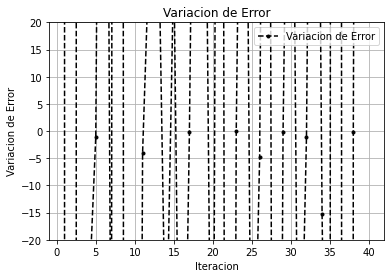

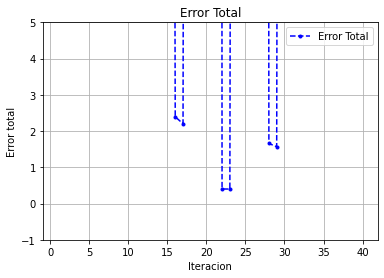

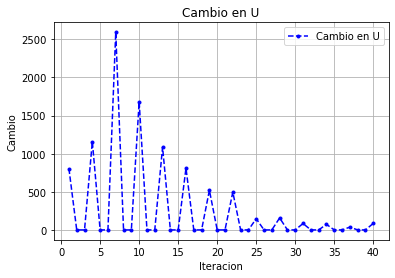

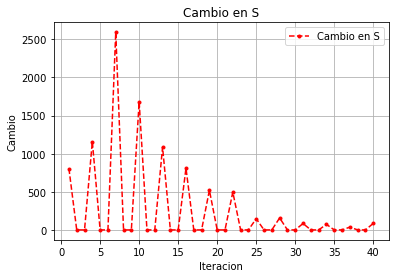

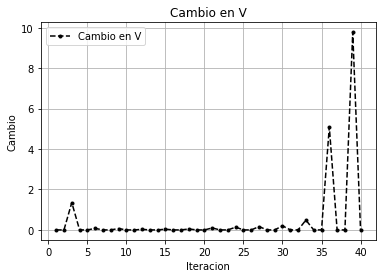


FIN TOTAL



In [39]:
########################  Entrenamiento y Validacion  #########################################

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

# Opcion 01

### Opcion 01 - Positivo = 0



-----------------------------
Opcion Optimizacion Gradientes:  1 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
1.82 7.99 6.89 
0.40 1.82 1.57 
1.34 5.87 5.05 
0.43 2.25 2.05 
Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 1 ; tiempo de bucle: 1.68854 seg.


-----------------------------
Opcion Optimizacion Gradientes:  1 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
24.39 105.58 92.59 
5.31 24.34 21.37 
17.97 77.15 67.63 
14.84 60.51 56.42 
Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 2 ; tiempo de bucle: 1.48172 seg.


-----------------------------
Opcion Optimizacion Gradientes:  1 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
12.02 5.80 -8.67 
2.63 1.38

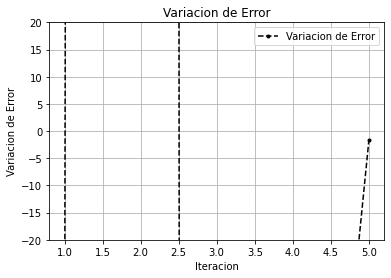

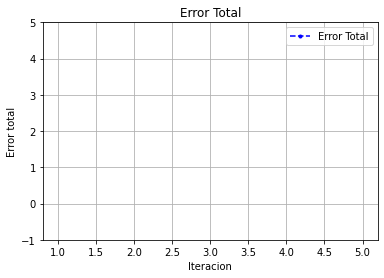

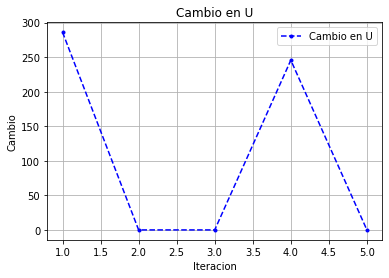

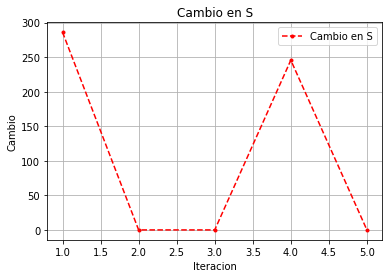

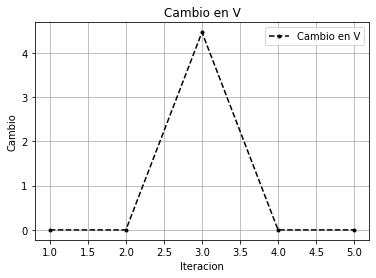


FIN TOTAL



In [12]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 0      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 1

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

### Opcion 01 - Positivo = 1



-----------------------------
Opcion Optimizacion Gradientes:  1 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
4.99 2.18 3.53 
5.57 3.36 4.00 
6.94 4.30 5.11 
4.96 2.74 3.55 
Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 1 ; tiempo de bucle: 1.33445 seg.


-----------------------------
Opcion Optimizacion Gradientes:  1 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
24.72 10.59 17.75 
1.35 0.58 0.97 
1.98 0.85 1.42 
8.62 3.69 6.19 
Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 2 ; tiempo de bucle: 1.51793 seg.


-----------------------------
Opcion Optimizacion Gradientes:  1 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
5.28 9.14 8.09 
0.29 0.50 0.44 
0.42

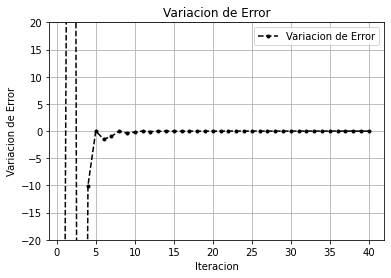

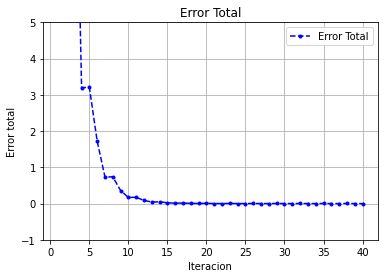

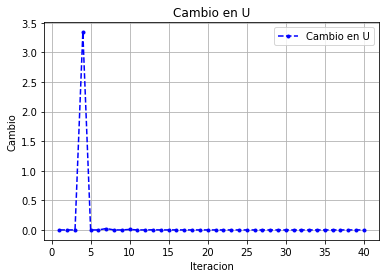

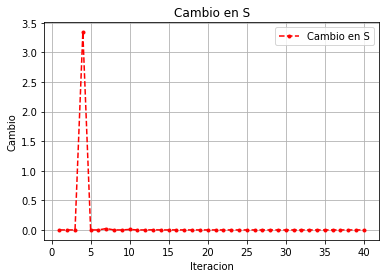

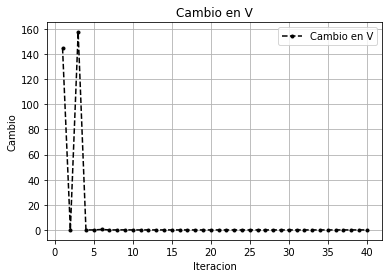


FIN TOTAL



In [13]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 1      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 1

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

# Opcion 02

### Opcion 02 - Positivo = 0



-----------------------------
Opcion Optimizacion Gradientes:  2 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
1.94 1.53 1.57 
1.61 0.99 1.37 
0.22 0.18 0.16 
1.73 1.06 1.53 
Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 1 ; tiempo de bucle: 1.32251 seg.


-----------------------------
Opcion Optimizacion Gradientes:  2 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
3.07 2.37 2.55 
2.44 1.41 2.24 
0.34 0.26 0.26 
2.66 1.55 2.51 
Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 2 ; tiempo de bucle: 0.24533 seg.


-----------------------------
Opcion Optimizacion Gradientes:  2 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
5.46 3.92 9.99 
4.07 3.06 8.18 
0.58 0.

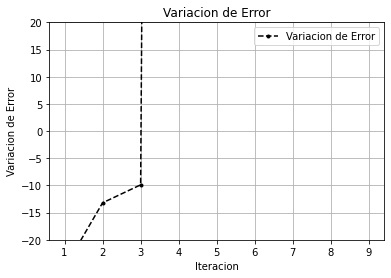

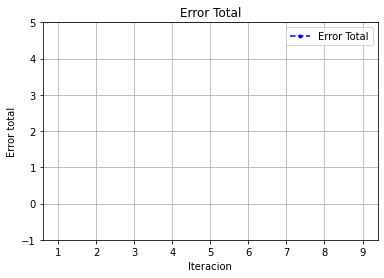

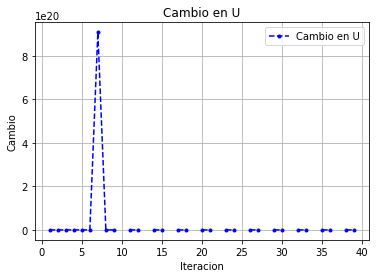

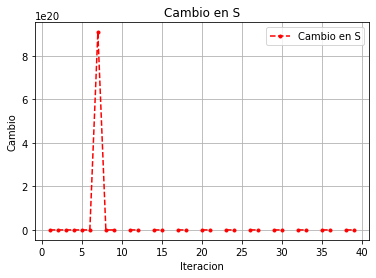

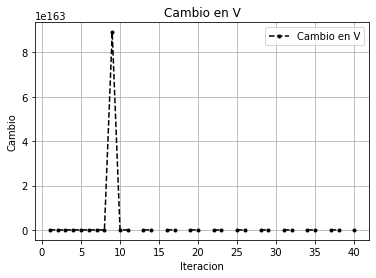


FIN TOTAL



In [14]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 0      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 2

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

### Opcion 02 - Positivo = 1



-----------------------------
Opcion Optimizacion Gradientes:  2 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
0.69 0.99 0.62 
0.32 0.90 0.97 
0.23 0.60 0.38 
0.43 0.67 0.27 
Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 1 ; tiempo de bucle: 1.41724 seg.


-----------------------------
Opcion Optimizacion Gradientes:  2 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
1.00 1.46 1.10 
0.52 1.30 1.47 
0.29 0.74 0.48 
0.57 0.88 0.41 
Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 2 ; tiempo de bucle: 0.25332 seg.


-----------------------------
Opcion Optimizacion Gradientes:  2 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
1.81 1.70 2.57 
0.98 1.43 2.18 
0.52 0.

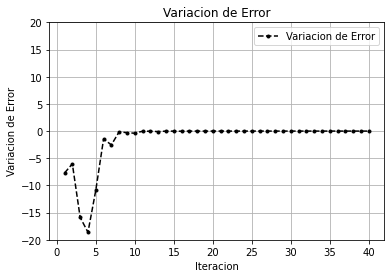

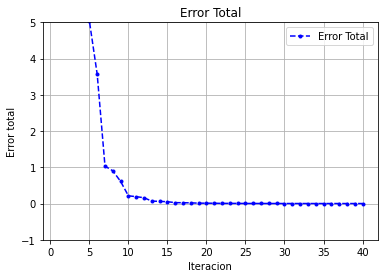

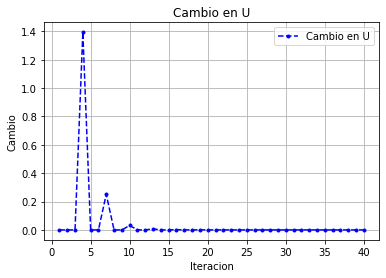

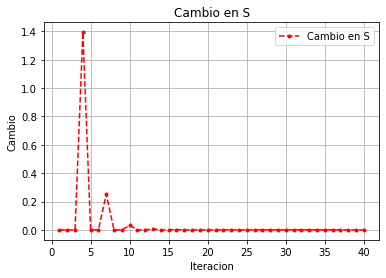

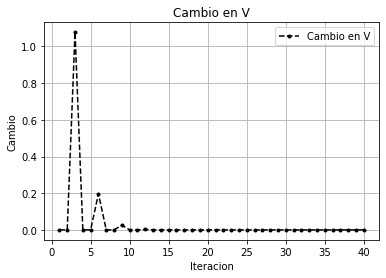


FIN TOTAL



In [15]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 1      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 2

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

# Opcion 03

### Opcion 03 - Positivo = 0



-----------------------------
Opcion Optimizacion Gradientes:  3 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
0.44 0.86 0.85 
0.47 0.91 0.91 
0.27 0.40 0.50 
0.40 0.65 0.76 
Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 1 ; tiempo de bucle: 1.39229 seg.


-----------------------------
Opcion Optimizacion Gradientes:  3 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
0.68 1.20 1.28 
0.71 1.25 1.34 
0.44 0.65 0.81 
0.64 1.00 1.19 
Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 2 ; tiempo de bucle: 0.25161 seg.


-----------------------------
Opcion Optimizacion Gradientes:  3 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
3.99 2.55 7.11 
4.16 2.62 7.42 
2.42 2.

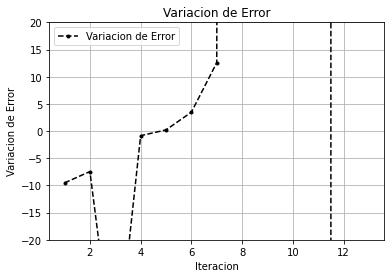

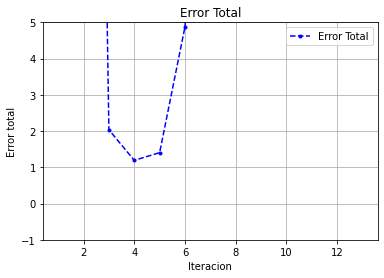

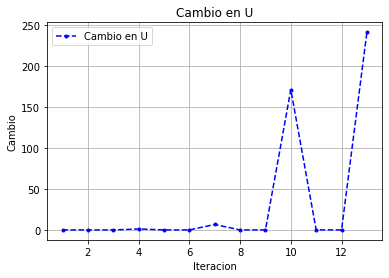

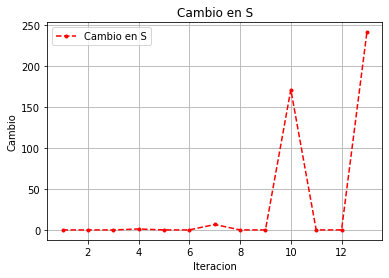

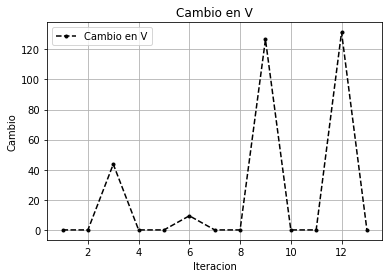


FIN TOTAL



In [16]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 0      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 3

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

### Opcion 03 - Positivo = 1



-----------------------------
Opcion Optimizacion Gradientes:  3 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
0.90 0.75 0.90 
0.19 0.09 0.16 
0.70 0.50 0.66 
0.77 0.67 0.80 
Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 1 ; tiempo de bucle: 1.40935 seg.


-----------------------------
Opcion Optimizacion Gradientes:  3 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
1.23 0.96 1.20 
0.24 0.12 0.21 
0.93 0.64 0.87 
1.10 0.88 1.09 
Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 2 ; tiempo de bucle: 0.26430 seg.


-----------------------------
Opcion Optimizacion Gradientes:  3 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
5.12 8.24 3.30 
0.84 1.33 0.37 
3.67 5.

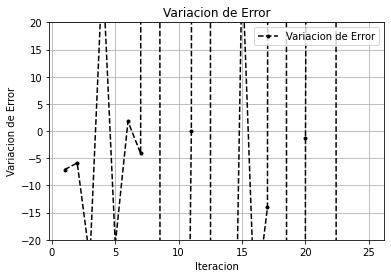

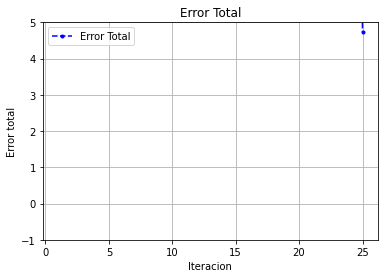

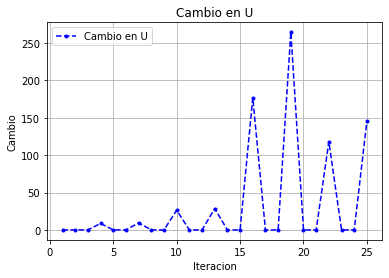

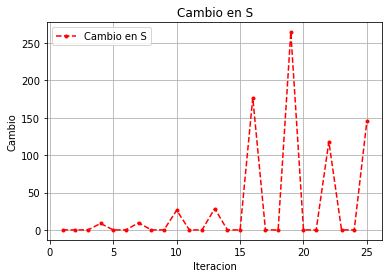

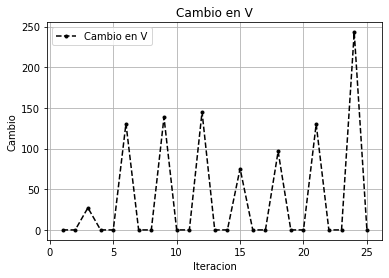


FIN TOTAL



In [17]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 1      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 3

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

# Opcion 04

### Opcion 04 - Positivo = 0



-----------------------------
Opcion Optimizacion Gradientes:  4 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
0.98 1.36 1.00 
0.52 0.62 0.56 
1.12 1.54 1.15 
0.59 0.82 0.61 
Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 1 ; tiempo de bucle: 1.29456 seg.


-----------------------------
Opcion Optimizacion Gradientes:  4 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
1.41 1.83 1.48 
0.75 0.86 0.81 
1.60 2.04 1.67 
0.89 1.15 0.94 
Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 2 ; tiempo de bucle: 0.24136 seg.


-----------------------------
Opcion Optimizacion Gradientes:  4 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
1.68 1.90 1.84 
0.88 0.90 1.00 
1.90 2.

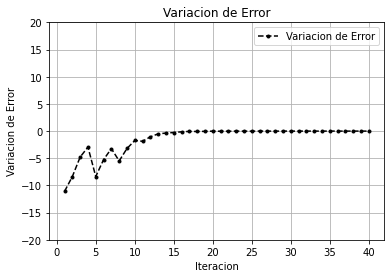

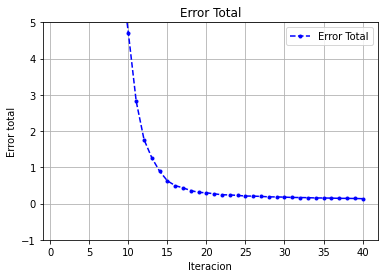

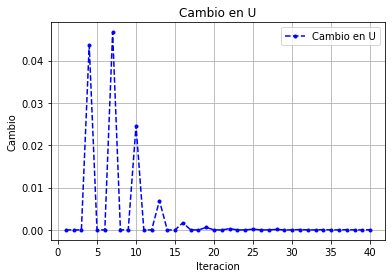

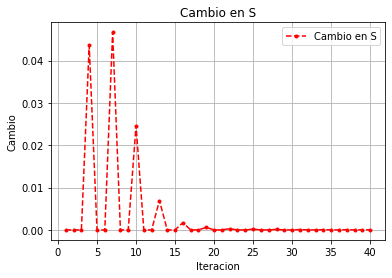

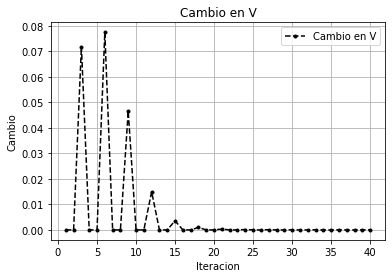


FIN TOTAL



In [18]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 0      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 4

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

### Opcion 04 - Positivo = 1



-----------------------------
Opcion Optimizacion Gradientes:  4 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
1.01 0.89 0.72 
1.00 0.95 0.62 
0.59 0.58 0.36 
0.73 0.60 0.62 
Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 1 ; tiempo de bucle: 1.40325 seg.


-----------------------------
Opcion Optimizacion Gradientes:  4 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
1.18 1.00 0.85 
1.16 1.05 0.74 
0.68 0.64 0.44 
0.88 0.69 0.73 
Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 2 ; tiempo de bucle: 0.25334 seg.


-----------------------------
Opcion Optimizacion Gradientes:  4 




----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
1.23 1.02 0.94 
1.21 1.07 0.82 
0.71 0.

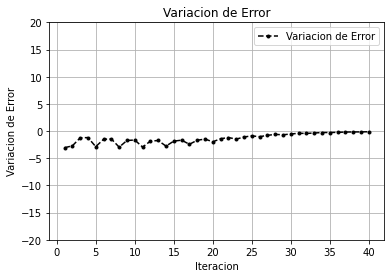

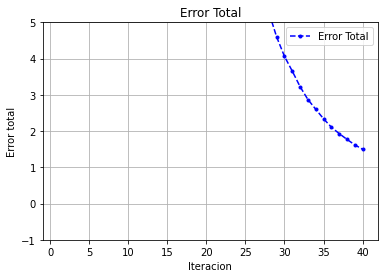

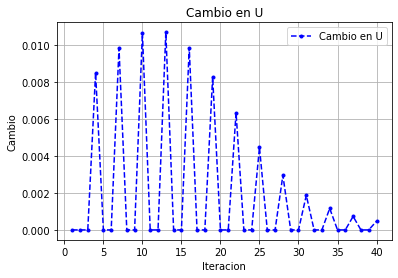

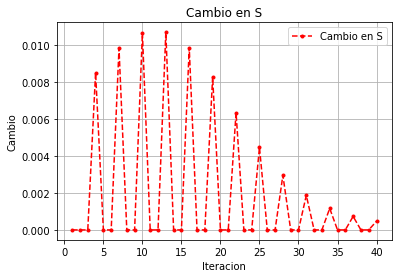

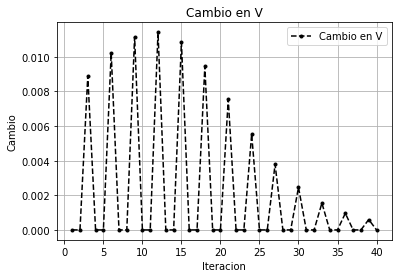


FIN TOTAL



In [19]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 1      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 4

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

# Opcion 05

### Opcion 05 - Positivo = 0



-----------------------------
Opcion Optimizacion Gradientes:  5 


Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion


----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
0.33 0.51 0.35 
0.33 0.73 0.44 
0.12 0.23 0.15 
0.16 0.35 0.22 
Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 1 ; tiempo de bucle: 2.09138 seg.


-----------------------------
Opcion Optimizacion Gradientes:  5 


Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion


----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
0.36 0.54 0.39 
0.35 0.75 0.48 
0.13 0.24 0.16 
0.18 0.38 0.24 
Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 2 ; tiempo de bucle: 2.10440 seg.


-----------------------------
Opcion Optimizac

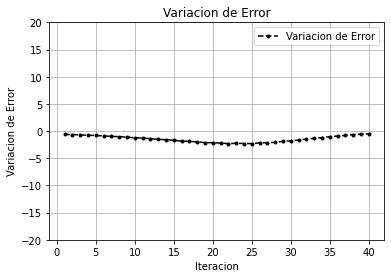

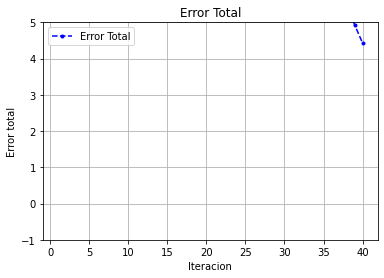

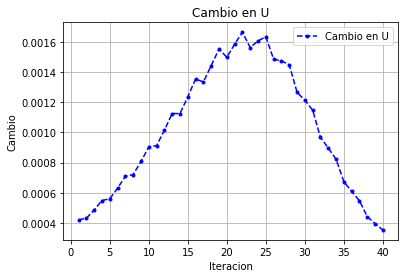

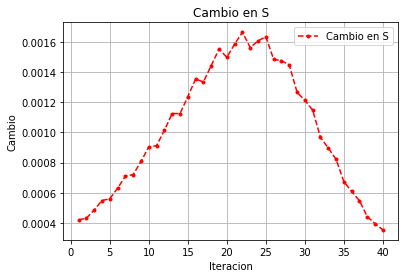

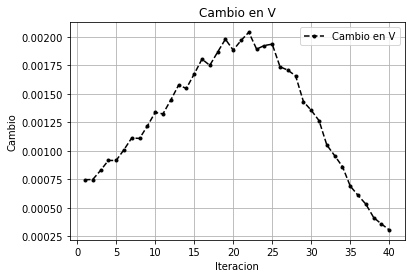


FIN TOTAL



In [20]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 0      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 5

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

### Opcion 05 - Positivo = 1



-----------------------------
Opcion Optimizacion Gradientes:  5 


Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion


----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
0.27 0.45 0.31 
0.51 0.85 0.69 
0.47 0.75 0.65 
0.86 1.13 1.05 
Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 1 ; tiempo de bucle: 2.15825 seg.


-----------------------------
Opcion Optimizacion Gradientes:  5 


Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion


----------------------------
Matriz Objectivo X0: 
[['5' 'n' '7']
 ['n' '2' 'n']
 ['4' 'n' 'n']
 ['n' '3' '6']]

Matriz obtenida: 
0.29 0.47 0.34 
0.52 0.87 0.71 
0.48 0.76 0.67 
0.89 1.16 1.09 
Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica
Iteracion: 2 ; tiempo de bucle: 2.17418 seg.


-----------------------------
Opcion Optimizac

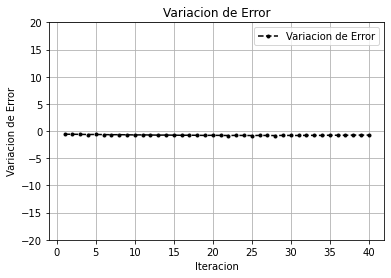

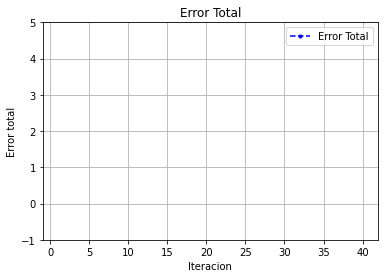

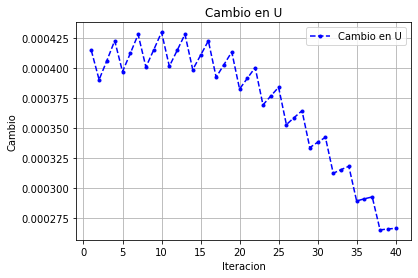

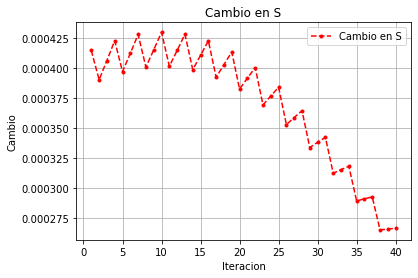

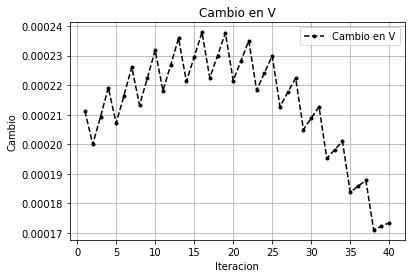


FIN TOTAL



In [21]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 1      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 5

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

# Opcion 06

### Opcion 06 - Positivo = 0

In [ ]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 0      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 6

### parametros a utilizar para el modelo
n_updates = 100  # cantidad de epochs de entrenamiento
umbral = 1e-6 ## colocado en porcentaje
lambda_= 0.04 ## parametro de regularizacion
usv = 1 ## empieza actualizando Vt y luego actualiza U
alpha = 0.4 # ratio de aprendizaje para el descenso de gradiente
ratio_decaimiento = 0.98 # ratio al cual va decayendo "alpha" que impacta en el descenso de gradiente



ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin

### Opcion 06 - Positivo = 1

In [ ]:
########################  Entrenamiento y Validacion  #########################################

#########################################
### Forzar a Coeficientes Positivos  ####
positivos = 1      # con esto se habilita el entrenamiento hacia coeficientes positivos
coef_posi = 0.001  # coeficiente del exponencial (exp((-xi))) para penalizar valores negativos de coeficiente entrenados
opcion = 6

### parametros a utilizar para el modelo
n_updates = 100  # cantidad de epochs de entrenamiento
umbral = 1e-6 ## colocado en porcentaje
lambda_= 0.04 ## parametro de regularizacion
usv = 1 ## empieza actualizando Vt y luego actualiza U
alpha = 0.2 # ratio de aprendizaje para el descenso de gradiente
ratio_decaimiento = 0.95 # ratio al cual va decayendo "alpha" que impacta en el descenso de gradiente

ixx,iyy=X0.shape ## dimension de la matriz objetivo

U=sym.Matrix(np.random.uniform(0,1,(ixx,dim_comun))) ## shape = X0_ixx x dim_comun
Vt=sym.Matrix(np.random.uniform(0,1,(dim_comun,iyy))) ## shape = dim_comun x X0_iyy
S= sym.Matrix(np.random.uniform(0,1,(dim_comun,dim_comun))) # shape = dim_comun x dim_comun

# Diagonalizar la matriz ... colocar 0 a los valores que no son diagonal
for i in range(dim_comun):
    for j in range(dim_comun):
        if(i != j):
            S[i,j]=0.0

U_inicio=U.copy() ## guardar valores iniciales de U
S_inicio=S.copy()  ## guardar valores iniciales de S
Vt_inicio=Vt.copy() ## guardar valores iniciales de Vt


## Matriz simbolica U , Vt y S
Ui=sym.MatrixSymbol('u',U.shape[0],U.shape[1]) ## matriz simbolica
Si=sym.MatrixSymbol('s',U.shape[1],Vt.shape[0]) ## matriz simbolica 
Vit=sym.MatrixSymbol('v',Vt.shape[0],Vt.shape[1]) ## matriz simbolica

## variables inicializadas y vacias
total_errores=[] ## guarda error inicial
cambio_errores=[] ## guarda el registro de errores
cambio_u=[]
cambio_s=[]
cambio_v=[]
cuenta=0
tt=[]

while(cuenta < n_updates):
    print('\n\n-----------------------------')
    print('Opcion Optimizacion Gradientes: ',opcion,'\n\n')
    t1=time.time()
    
    if(opcion==1):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==2):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==3):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    
    elif(opcion==4):
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_2(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==5):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_5(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
    elif(opcion==6):
        print('Aqui se entrena tanto U,S y V en el mismo epoch o iteracion. No ver el valor de usv de iteracion')
        U_new,S_new,Vt_new,variacion_U,variacion_S,variacion_V,variacion_error,error_total = actualizacion_matriz2_alt_6(X0,U,S,Vt,Ui,Si,Vit,usv,lambda_,entero,alpha,positivos,coef_posi)
        
    ###################################
    
    total_errores.append(error_total)
    cambio_errores.append(variacion_error)
    cambio_u.append(variacion_U)
    cambio_s.append(variacion_S)
    cambio_v.append(variacion_V)
  
    # En caso tanto U como Vt tengan signos negativos, cambiarlos a positivos
    # esto debido a que (-U)*S*(-Vt) == U*S*Vt ... es decir, el signo no afecta si se cambia tanto a U como Vt
    if((sum(U_new)<0) & (sum(Vt_new)<0)):
        U_new = -U_new
        Vt_new = -Vt_new
  
    resultados2(X0,U_new,S_new,Vt_new)

    U=U_new.copy()  ## actualizar valores de U
    S=S_new.copy()  ## actualizar valores de S
    Vt=Vt_new.copy()  ## actualizar valores de V

    cuenta +=1
    usv = (cuenta % 3)+1
    
    if(usv==1):
        print('Entrenamiento con variable U ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==2):
        print('Entrenamiento con variable S ... Solo opcion 1 al 4, 5-6 No aplica')
    elif(usv==3):
        print('Entrenamiento con variable V ... Solo opcion 1 al 4, 5-6 No aplica')
    
    # Se realiza un decaimiento del parametro de aprendizaje "alpha" que impacta en el calculo del descenso de gradiente
    if(usv==2):
        alpha= alpha*ratio_decaimiento 
    
    if(cuenta>4):
        if((total_errores[-1]) < (umbral)*np.mean(total_errores[-4:-1])):
            break

    t2=time.time()
    tt.append(t2-t1)
    print('Iteracion: %i ; tiempo de bucle: %.5f seg.' % (cuenta,t2-t1))


print('Se ha finalizado el entrenamiento')
print('Cantidad de iteraciones realizadas: ',cuenta)
print('Tiempo promedio por iteracion: %.4f seg.' % (np.mean(tt)))

##########################################################################

### Ver Matrices Resultantes (Entrenadas U,S y V):

print('\n\nResultado final X0 vs Xfinal:')
resultados2(X0,U,S,Vt)

# Ver resultado de matrices entrenadas U, S y Vt
print('\nVer Matriz U:')
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        print('%.2f ' % (U[i,j]),end='')
    print('')
print('--------------------------------------------')
print('\nVer Matriz S:')
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        print('%.2f ' % (S[i,j]),end='')
    print('')
print('--------------------------------------------')
print('Ver Matriz V:')
for i in range(Vt.T.shape[0]):
    for j in range(Vt.T.shape[1]):
        print('%.3f ' % (Vt.T[i,j]),end='')
    print('')  
print('\n\n')

##########################################################################

## Variacion de Error
plt.plot(range(1,1+len(cambio_errores)),cambio_errores,'--.k',label='Variacion de Error')
plt.title('Variacion de Error')
plt.xlabel('Iteracion')
plt.ylabel('Variacion de Error')
plt.legend()
plt.ylim(-20,20)
plt.grid(True)
plt.show()

## Error Total
plt.plot(range(1,1+len(total_errores)),total_errores,'--.b',label='Error Total')
plt.title('Error Total')
plt.xlabel('Iteracion')
plt.ylabel('Error total')
plt.legend()
plt.ylim(-1,5)
plt.grid(True)
plt.show()


# Cambio en U
plt.plot(range(1,1+len(cambio_u)),cambio_u,'--.b',label='Cambio en U')
plt.title('Cambio en U')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en S
plt.plot(range(1,1+len(cambio_s)),cambio_u,'--.r',label='Cambio en S')
plt.title('Cambio en S')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


# Cambio en V
plt.plot(range(1,1+len(cambio_v)),cambio_v,'--.k',label='Cambio en V')
plt.title('Cambio en V')
plt.xlabel('Iteracion')
plt.ylabel('Cambio')
plt.legend()
plt.grid(True)
plt.show()


print('\nFIN TOTAL\n')


# fin